<a href="https://colab.research.google.com/github/fikrifaizz/hr-attrition-optimizer/blob/main/notebooks/eda_cohort_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

In [2]:
df_raw = pd.read_csv("../data/raw/hr_raw.csv")

print(f"Dataset Shape: {df_raw.shape}")
df_raw.head()

Dataset Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# 1. Cek Missing Values
missing = df_raw.isnull().sum()
missing = missing[missing > 0]

# 2. Cek Duplikasi Baris
duplicates = df_raw.duplicated().sum()

print(f"Jumlah Missing Values: {len(missing)}")
if len(missing) > 0:
    print(missing)
else:
    print("Tidak ada missing values (Clean Dataset).")

print(f"Jumlah Duplikasi Baris: {duplicates}")

Jumlah Missing Values: 0
Tidak ada missing values (Clean Dataset).
Jumlah Duplikasi Baris: 0


In [4]:
# Cek kolom yang hanya punya 1 nilai unik
unique_counts = df_raw.nunique()
useless_cols = unique_counts[unique_counts == 1].index.tolist()

print("KOLOM SAMPAH (Variance = 0):")
print(useless_cols)

# Cek juga kolom Identifier (Unik untuk setiap baris)
id_cols = unique_counts[unique_counts == df_raw.shape[0]].index.tolist()
print(f"\nKOLOM IDENTIFIER (Mungkin perlu dibuang): {id_cols}")

KOLOM SAMPAH (Variance = 0):
['EmployeeCount', 'Over18', 'StandardHours']

KOLOM IDENTIFIER (Mungkin perlu dibuang): ['EmployeeNumber']


In [11]:
display(df_raw.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


Distribusi Target (Attrition):
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_50460/2936752462.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')


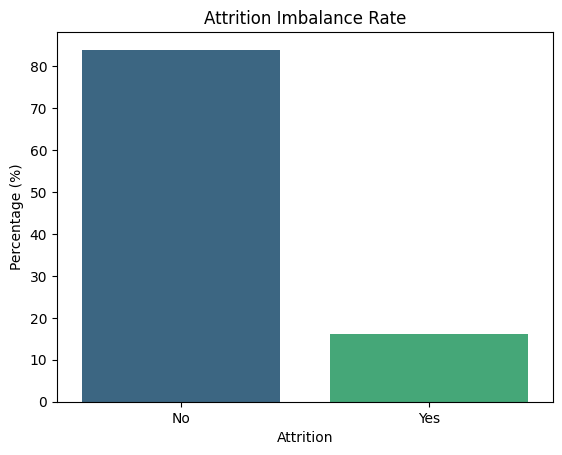

In [8]:
# Hitung distribusi target
target_counts = df_raw['Attrition'].value_counts(normalize=True) * 100

print("Distribusi Target (Attrition):")
print(target_counts)

# Visualisasi
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
plt.title("Attrition Imbalance Rate")
plt.ylabel("Percentage (%)")
plt.show()

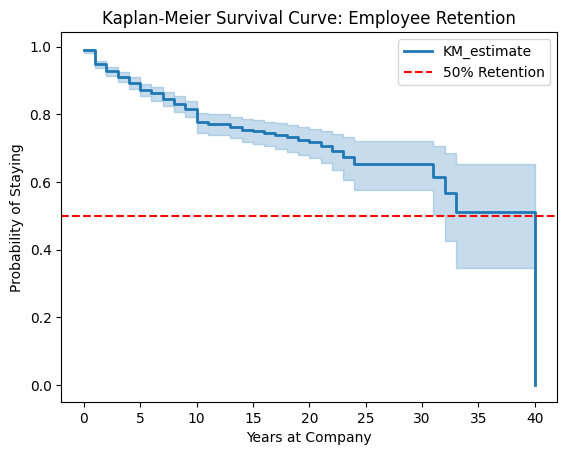

Probabilitas bertahan setelah 5 tahun: 0.87
Probabilitas bertahan setelah 10 tahun: 0.78


In [9]:
# Persiapan Data untuk Lifelines
# Event harus 1 (Yes) atau 0 (No)
T = df_raw['YearsAtCompany'] # Time (Durasi)
E = df_raw['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0) # Event (Kejadian)

kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)

# Plotting
kmf.plot_survival_function(linewidth=2)
plt.title("Kaplan-Meier Survival Curve: Employee Retention")
plt.xlabel("Years at Company")
plt.ylabel("Probability of Staying")
plt.axhline(0.5, color='r', linestyle='--', label='50% Retention')
plt.legend()
plt.show()

print(f"Probabilitas bertahan setelah 5 tahun: {kmf.predict(5):.2f}")
print(f"Probabilitas bertahan setelah 10 tahun: {kmf.predict(10):.2f}")